Model Shellinga

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

Funkcja do inicjalizacji siatki

In [19]:
def initializeGrid(grid_size=50, density=0.75):
    num_cells = grid_size**2
    num_agents = int(num_cells * density)
    num_agents = (num_agents // 2) * 2
    agents = np.array([1] * (num_agents // 2) + [2] * (num_agents // 2) + [0] * (num_cells - num_agents))
    np.random.shuffle(agents)
    return agents.reshape(grid_size, grid_size)


Funkcja do pobrania informacji o sąsiadach(8 sąsiadów), oraz funkcja do pobrania tylko najbliższych sąsiadów(4 sądiadów)

In [20]:
def getNeighbors(grid, x, y):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                neighbors.append(grid[nx, ny])
    return neighbors

In [21]:
def getDirectNeighbors(grid, x, y):
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
            neighbors.append(grid[nx, ny])
    return neighbors

Funkcja do sprawdzania zadowolenia agenta, na podstawie zadanej tolerancji

In [42]:
def isSatisfied(grid, x, y, tolerance):
    agent = grid[x, y]
    if agent == 0:
        return True
    neighbors = getDirectNeighbors(grid, x, y)
    if not neighbors:
        return False
    sameType = sum(1 for n in neighbors if n == agent)
    return sameType / len(neighbors) >= tolerance

Funkcja służąca do pobrania losowego agenta

In [43]:
def getRandomAgent(grid):
    allAgents = [(x, y) for x in range(grid.shape[0]) for y in range(grid.shape[1]) if grid[x, y] != 0]
    if not allAgents:
        return grid, False

    randomAgent = random.choice(allAgents)
    return randomAgent

Funkcja służąca do wykonania jednego kroku symulacji

In [63]:
def step(agent, grid, tolerance):
    x, y = agent
    if isSatisfied(grid, x, y, tolerance):
        return grid, False

    emptySpots = [(x, y) for x in range(grid.shape[0]) for y in range(grid.shape[1]) if grid[x, y] == 0]
    if emptySpots:
        newX, newY = random.choice(emptySpots)
        grid[newX, newY] = grid[x, y]
        grid[x, y] = 0
        return grid, True

    return grid, False


Funkcja główna służąca do symulacji

In [66]:
def runSchellingSimulation(grid_size=50, density=0.75, tolerance=0.3, plot_iterations=[1, 5000, 10000]):
    grid = initializeGrid(grid_size, density)
    plt.figure(figsize=(6, 6))
    iteration = 0
    while True:
        agent = getRandomAgent(grid)
        grid, has_moved = step(agent, grid, tolerance)
        iteration += 1


        if iteration in plot_iterations:
            plt.imshow(grid, cmap='Set1', vmin=0, vmax=2)
            plt.title(f'Iteration: {iteration}')
            plt.show(block=False)
            plt.pause(0.1)

        if iteration == 10000: #TODO: poprawic to na warunek kiedy zadowolenie praktycznie bedzie stale
            break

    plt.show()



Symulacja dla zapełnienia 75%, z analiz wynika że Tc = 26%
Pierwsza seria rysunków dla Tolerancji krytycznej, druga obrazująca brak segregacji

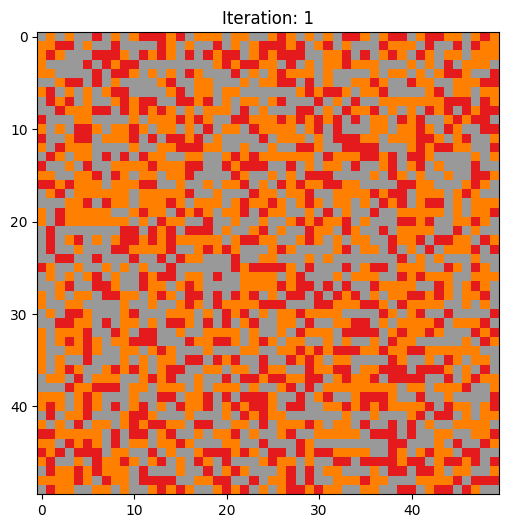

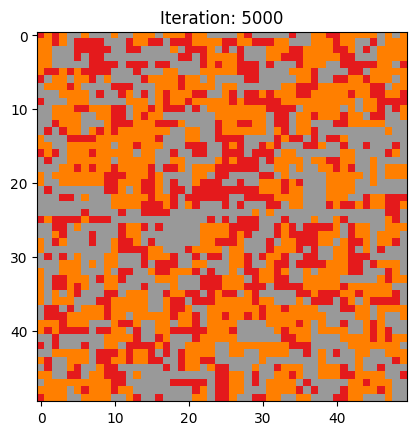

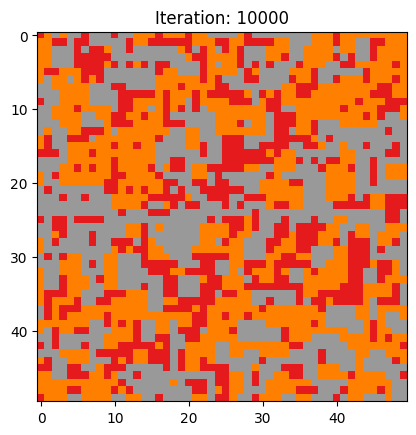

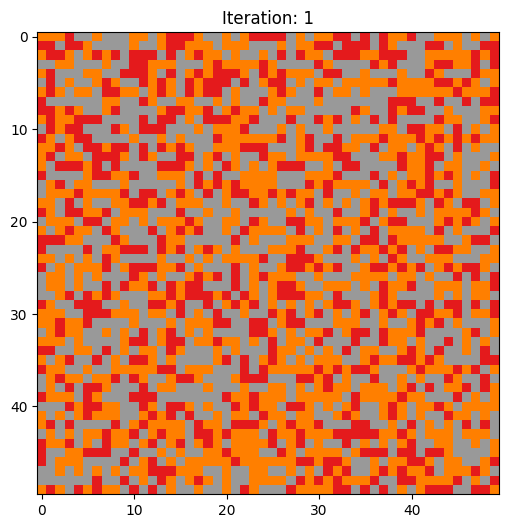

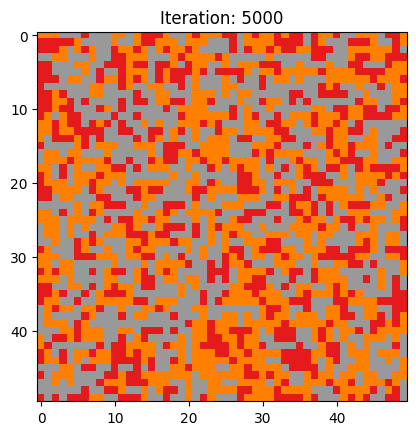

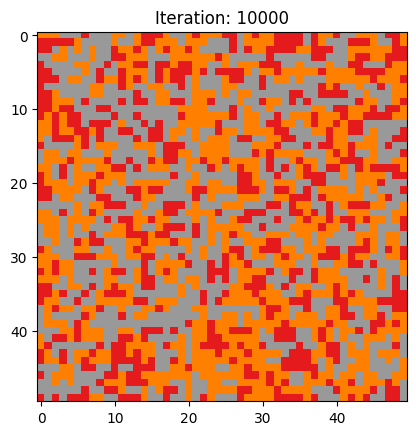

In [82]:
runSchellingSimulation(grid_size=50, density=0.75, tolerance=0.26)
runSchellingSimulation(grid_size=50, density=0.75, tolerance=0.2)

Symulacja dla zapełnienia 85%, z analiz wynika że Tc = 26%
Pierwsza seria rysunków dla Tolerancji krytycznej, druga obrazująca brak segregacji

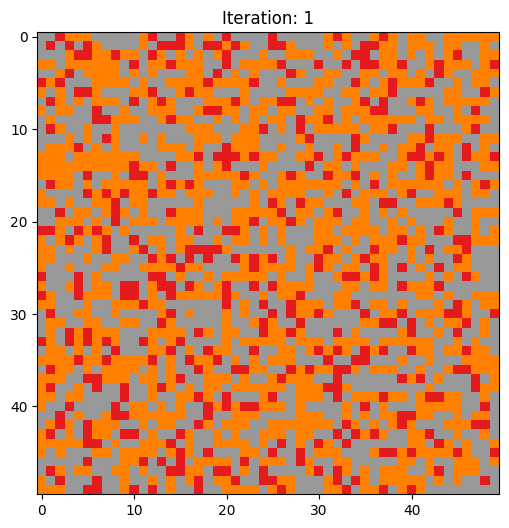

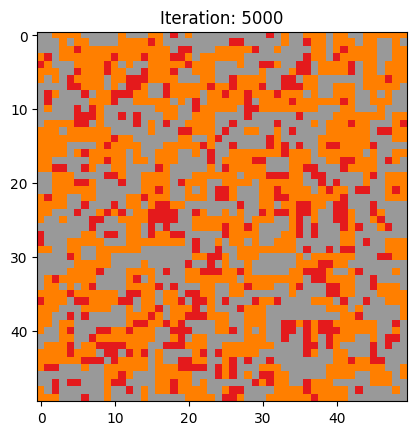

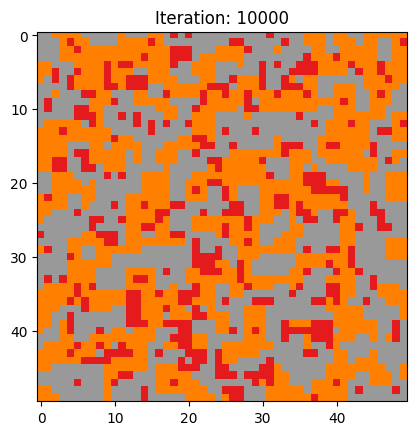

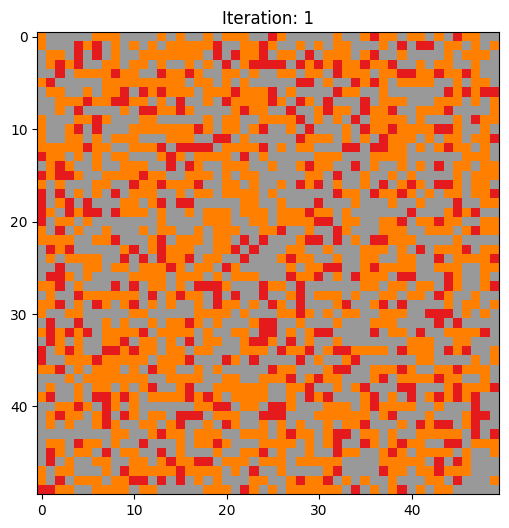

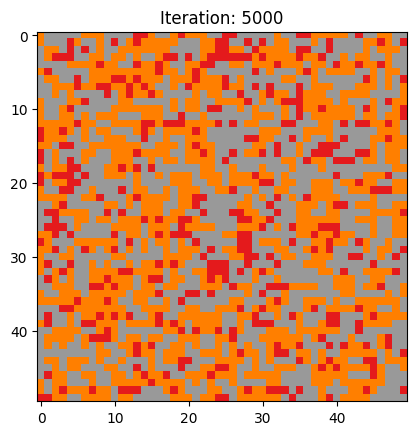

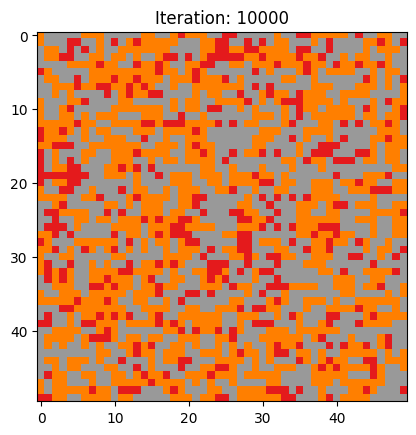

In [92]:
runSchellingSimulation(grid_size=50, density=0.85, tolerance=0.26)
runSchellingSimulation(grid_size=50, density=0.85, tolerance=0.25)

Symulacja dla zapełnienia 95%, z analiz wynika że Tc = 26%
Pierwsza seria rysunków dla Tolerancji krytycznej, druga obrazująca brak segregacji

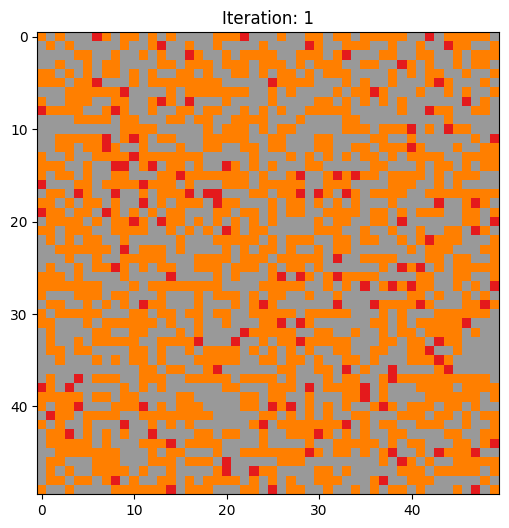

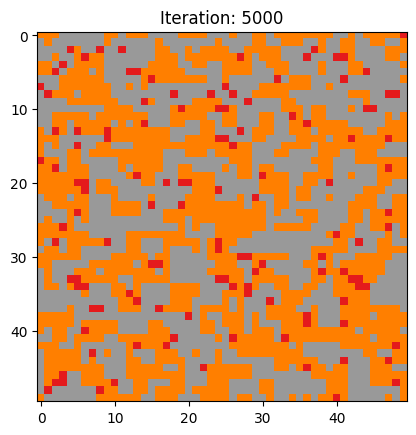

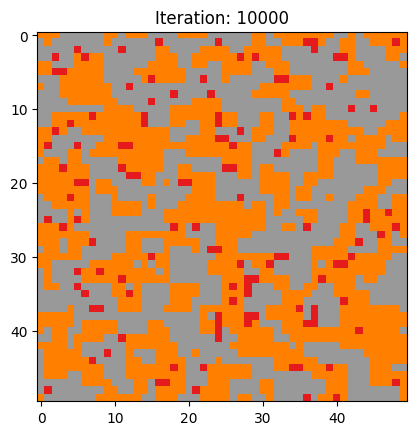

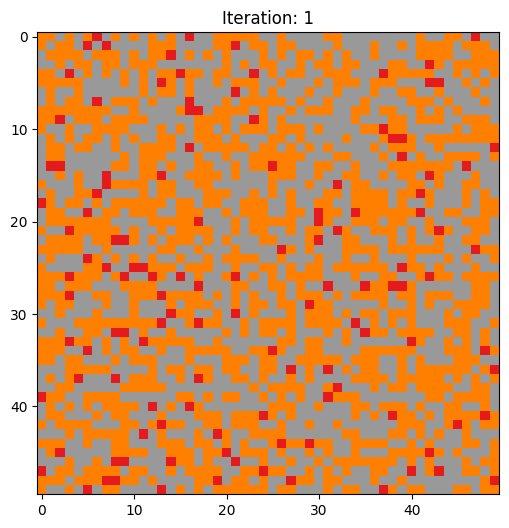

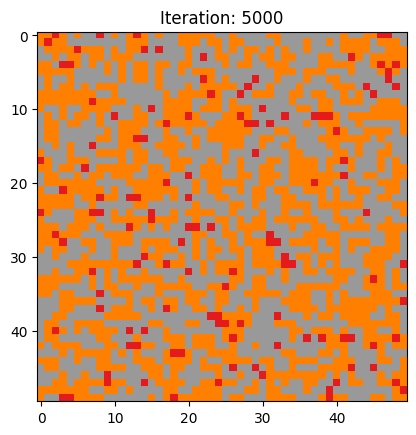

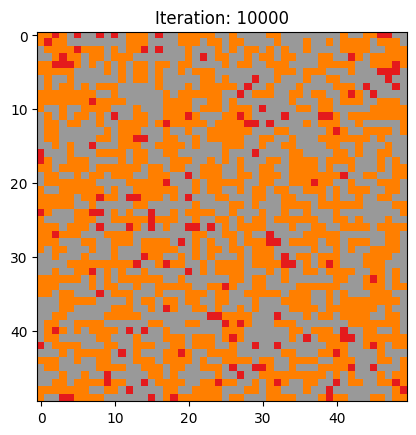

In [98]:
runSchellingSimulation(grid_size=50, density=0.95, tolerance=0.26)
runSchellingSimulation(grid_size=50, density=0.95, tolerance=0.25)